In [1]:
%matplotlib inline


# Kernel PCA

This example shows the difference between the Principal Components Analysis
(:class:`~sklearn.decomposition.PCA`) and its kernalized version
(:class:`~sklearn.decomposition.KernelPCA`).

On the one hand, we show that :class:`~sklearn.decomposition.KernelPCA` is able
to find a projection of the data which linearly separates them while it is not the case
with :class:`~sklearn.decomposition.PCA`.

Finally, we show that inverting this projection is an approximation with
:class:`~sklearn.decomposition.KernelPCA`, while it is exact with
:class:`~sklearn.decomposition.PCA`.


## Projecting data: `PCA` vs. `KernelPCA`

In this section, we show the advantages of using a kernel when
projecting data using a Principal Component Analysis (PCA). We create a
dataset made of two nested circles.



In [3]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

Let's have a quick first look at the generated dataset.



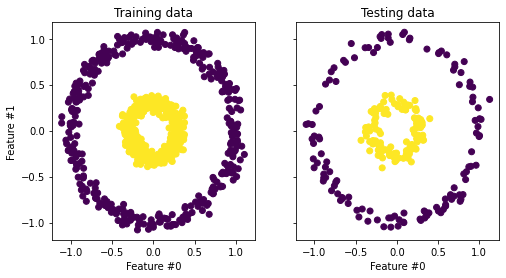

In [4]:
import matplotlib.pyplot as plt

_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

The samples from each class cannot be linearly separated: there is no
straight line that can split the samples of the inner set from the outer
set.

Now, we will use PCA with and without a kernel to see what is the effect of
using such a kernel. The kernel used here is a radial basis function (RBF)
kernel.



In [5]:
from sklearn.decomposition import PCA, KernelPCA

pca = PCA(n_components=2)
kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
)

X_test_pca = pca.fit(X_train).transform(X_test)
X_test_kernel_pca = kernel_pca.fit(X_train).transform(X_test)

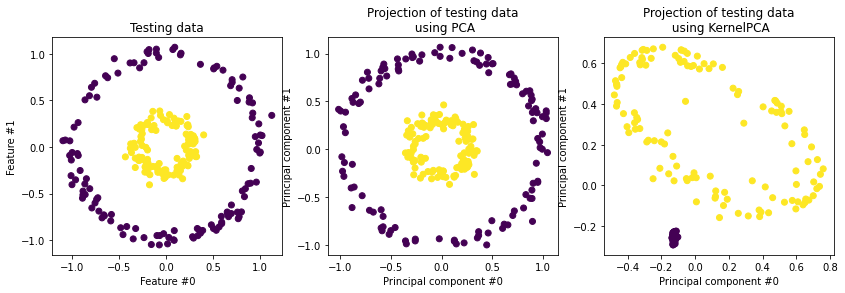

In [6]:
fig, (orig_data_ax, pca_proj_ax, kernel_pca_proj_ax) = plt.subplots(
    ncols=3, figsize=(14, 4)
)

orig_data_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
orig_data_ax.set_ylabel("Feature #1")
orig_data_ax.set_xlabel("Feature #0")
orig_data_ax.set_title("Testing data")

pca_proj_ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test)
pca_proj_ax.set_ylabel("Principal component #1")
pca_proj_ax.set_xlabel("Principal component #0")
pca_proj_ax.set_title("Projection of testing data\n using PCA")

kernel_pca_proj_ax.scatter(X_test_kernel_pca[:, 0], X_test_kernel_pca[:, 1], c=y_test)
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_xlabel("Principal component #0")
_ = kernel_pca_proj_ax.set_title("Projection of testing data\n using KernelPCA")

We recall that PCA transforms the data linearly. Intuitively, it means that
the coordinate system will be centered, rescaled on each component
with respected to its variance and finally be rotated.
The obtained data from this transformation is isotropic and can now be
projected on its *principal components*.

Thus, looking at the projection made using PCA (i.e. the middle figure), we
see that there is no change regarding the scaling; indeed the data being two
concentric circles centered in zero, the original data is already isotropic.
However, we can see that the data have been rotated. As a
conclusion, we see that such a projection would not help if define a linear
classifier to distinguish samples from both classes.

Using a kernel allows to make a non-linear projection. Here, by using an RBF
kernel, we expect that the projection will unfold the dataset while keeping
approximately preserving the relative distances of pairs of data points that
are close to one another in the original space.

We observe such behaviour in the figure on the right: the samples of a given
class are closer to each other than the samples from the opposite class,
untangling both sample sets. Now, we can use a linear classifier to separate
the samples from the two classes.

## Projecting into the original feature space

One particularity to have in mind when using
:class:`~sklearn.decomposition.KernelPCA` is related to the reconstruction
(i.e. the back projection in the original feature space). With
:class:`~sklearn.decomposition.PCA`, the reconstruction will be exact if
`n_components` is the same than the number of original features.
This is the case in this example.

We can investigate if we get the original dataset when back projecting with
:class:`~sklearn.decomposition.KernelPCA`.



In [7]:
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test))
X_reconstructed_kernel_pca = kernel_pca.inverse_transform(kernel_pca.transform(X_test))

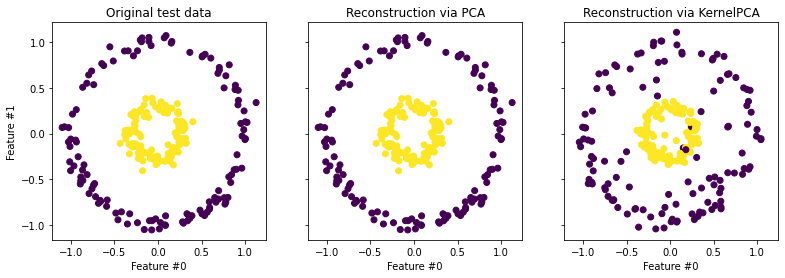

In [8]:
fig, (orig_data_ax, pca_back_proj_ax, kernel_pca_back_proj_ax) = plt.subplots(
    ncols=3, sharex=True, sharey=True, figsize=(13, 4)
)

orig_data_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
orig_data_ax.set_ylabel("Feature #1")
orig_data_ax.set_xlabel("Feature #0")
orig_data_ax.set_title("Original test data")

pca_back_proj_ax.scatter(X_reconstructed_pca[:, 0], X_reconstructed_pca[:, 1], c=y_test)
pca_back_proj_ax.set_xlabel("Feature #0")
pca_back_proj_ax.set_title("Reconstruction via PCA")

kernel_pca_back_proj_ax.scatter(
    X_reconstructed_kernel_pca[:, 0], X_reconstructed_kernel_pca[:, 1], c=y_test
)
kernel_pca_back_proj_ax.set_xlabel("Feature #0")
_ = kernel_pca_back_proj_ax.set_title("Reconstruction via KernelPCA")

While we see a perfect reconstruction with
:class:`~sklearn.decomposition.PCA` we observe a different result for
:class:`~sklearn.decomposition.KernelPCA`.

Indeed, :meth:`~sklearn.decomposition.KernelPCA.inverse_transform` cannot
rely on an analytical back-projection and thus an exact reconstruction.
Instead, a :class:`~sklearn.kernel_ridge.KernelRidge` is internally trained
to learn a mapping from the kernalized PCA basis to the original feature
space. This method therefore comes with an approximation introducing small
differences when back projecting in the original feature space.

To improve the reconstruction using
:meth:`~sklearn.decomposition.KernelPCA.inverse_transform`, one can tune
`alpha` in :class:`~sklearn.decomposition.KernelPCA`, the regularization term
which controls the reliance on the training data during the training of
the mapping.

